# Problem-Specific Coordinate Generation for HyperNEAT Substrates

# Part 4: Evaluation

This is the final part for evaluation

## Setup

### Imports

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from config import config

### Setup / Define Folder Structure

This script assumes that the neuroevolution script has run and the file with the results is still in its output_directory. The evaluation files for the charts will be placed in a different output directory which needs to be setup.

In [2]:
eval_output_dir = "output_eval"
if not os.path.exists(eval_output_dir):
    os.mkdir(eval_output_dir)
output_dir_evolution = config["experiment"]["output_dir_evolution"]

df = pd.read_csv(f"{output_dir_evolution}/summary_results.csv")

### Setup color style with color palette

A robust colorblind-friendly palette based on the number of features depicted is used for accessability.

In [3]:
OKABE_ITO = [
    "#000000",  # black
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#CC79A7",  # reddish purple
]
EXTRA_COLORS = ["#999999", "#8DD3C7", "#BEBADA", "#80B1D3", "#FB8072", "#FDB462"]

def make_palette_for_levels(levels):
    """
    Returns a list of colors matching the number of `levels` with colorblind-friendly colors.
    """
    n = len(levels)
    base = OKABE_ITO.copy()
    if n > len(base):
        base = base + EXTRA_COLORS
    if n <= len(base):
        return base[:n]
    # If still more, fall back to HUSL for the remainder
    remainder = sns.color_palette("husl", n - len(base))
    return base + remainder

def markers_for_levels(levels):
    base = ["o", "s", "D", "<", ">", "X"]
    if len(levels) <= len(base):
        return base[:len(levels)]
    # repeat if too many
    reps = int(np.ceil(len(levels) / len(base)))
    return (base * reps)[:len(levels)]

def linestyles_for_levels(levels):
    base = ["-", "--", ":"]
    if len(levels) <= len(base):
        return base[:len(levels)]
    reps = int(np.ceil(len(levels) / len(base)))
    return (base * reps)[:len(levels)]

sns.set_theme(style="whitegrid", context="paper")  # readable grid & larger fonts

The sampling tags are replaced in the legends for more clarity.

In [4]:
legend_names = {
    "trained": "Sampling from Trained Agent",
    "random": "Random Policy Sampling",
    "no_data": "Random Coordinates",
    "manual": "Manually-set Coordinates",
}

if pd.api.types.is_categorical_dtype(df['sampling']):
    current = list(df['sampling'].cat.categories)
    rename_sub = {k: v for k, v in legend_names.items() if k in current}
    df['sampling'] = df['sampling'].cat.rename_categories(rename_sub)
else:
    # For non-categorical column
    df['sampling'] = df['sampling'].replace(legend_names)


/tmp/ipykernel_87389/3934498023.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df['sampling']):


## Evaluation

The categories for plotting need be defined first. Extra categories are used to filter for data sampling strategy.

In [5]:
df_filtered = df.query('method != "inv_pca"').copy()

df['method'] = df_filtered['method'].astype('category')
df['sampling'] = df_filtered['sampling'].astype('category')
df['dimensionality'] = df_filtered['dimensionality'].astype('category')
df_no_trained = df_filtered.query('sampling != "Sampling from Trained Agent"').copy()
df_no_random = df_filtered.query('sampling != "Random Policy Sampling"').copy()
df_no_manual = df_filtered.query('sampling != "Manually-set Coordinates"').copy()
df_only_random = df_filtered.query('sampling == "Random Policy Sampling"').copy()
df_only_trained = df_filtered.query('sampling == "Sampling from Trained Agent"').copy()

### Main Effect Charts

A custom plot function is used to plot min mean and max for the main effect charts.

In [6]:
def plot_range_mean_max(
    df_in: pd.DataFrame,
    group_col: str,
    value_col: str,
    title: str,
    outpath: str,
    order_by: str = "max_val",       # sort by 'max_val' (or 'mean_val'/'min_val')
    ascending: bool = True,
    mean_color: str = "#2898DA",     # colorblind-friendly blue
    max_color: str = "#D55E00",      # Okabe–Ito vermillion
    figsize=(10, 6),
):
    """
    Creates a horizontal min–mean–max chart grouped by `group_col`.
    Saves to `outpath`.
    """
    # Aggregate
    agg = (df_in.groupby(group_col, observed=True)[value_col]
           .agg(min_val='min', mean_val='mean', max_val='max')
           .reset_index())

    # Sort by chosen statistic
    agg = agg.sort_values(order_by, ascending=ascending).reset_index(drop=True)

    # Plot
    y = np.arange(len(agg))
    fig, ax = plt.subplots(figsize=figsize)
    # Range line (min → max)
    ax.hlines(y=y, xmin=agg['min_val'], xmax=agg['max_val'],
              color='#555555', linewidth=2)
    # Mean marker
    ax.plot(agg['mean_val'], y, 'o', color=mean_color, markersize=9, label='mean')
    # Max marker
    ax.plot(agg['max_val'], y, '*', color=max_color, markersize=9, label='max')

    # Ticks/labels
    ax.set_yticks(y)
    ax.set_yticklabels(agg[group_col].astype(str))
    ax.set_xlabel(value_col.replace("_", " ").title())
    ax.set_ylabel(group_col)
    ax.set_title(title)
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    ax.legend()
    plt.tight_layout()

    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    plt.savefig(outpath, dpi=150)
    plt.show()
    plt.close()


The reduction method plotted as main effect.

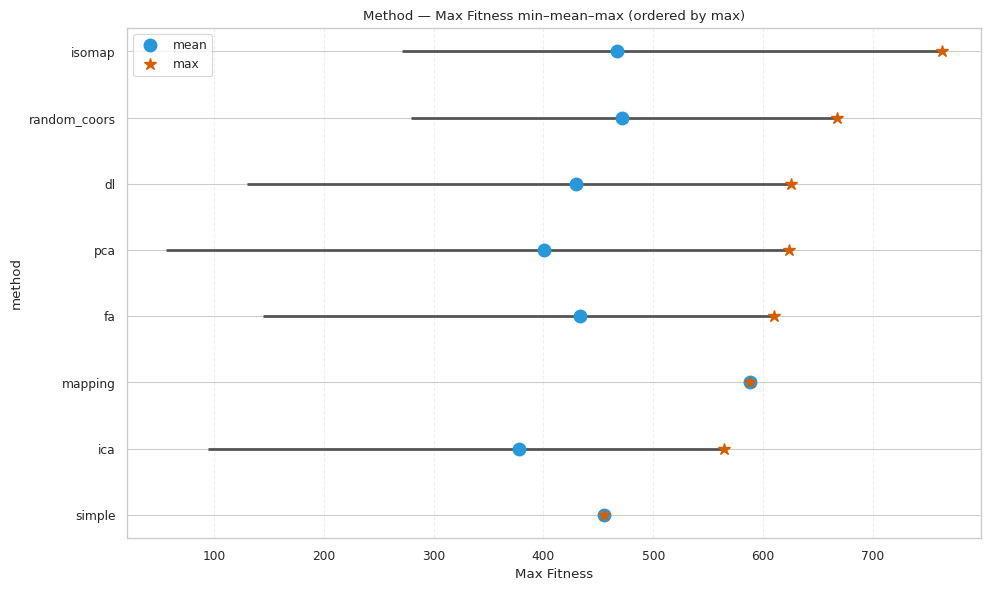

In [7]:
plot_range_mean_max(
    df_in=df,
    group_col='method',
    value_col='max_fitness',
    title='Method — Max Fitness min–mean–max (ordered by max)',
    outpath=os.path.join(eval_output_dir, "main_effect_method_range_mean_max.png"),
    order_by='max_val',
    ascending=True,
    figsize=(10, 6),
)

The reduction method, excluding the results from the trained agent, plotted as main effect.

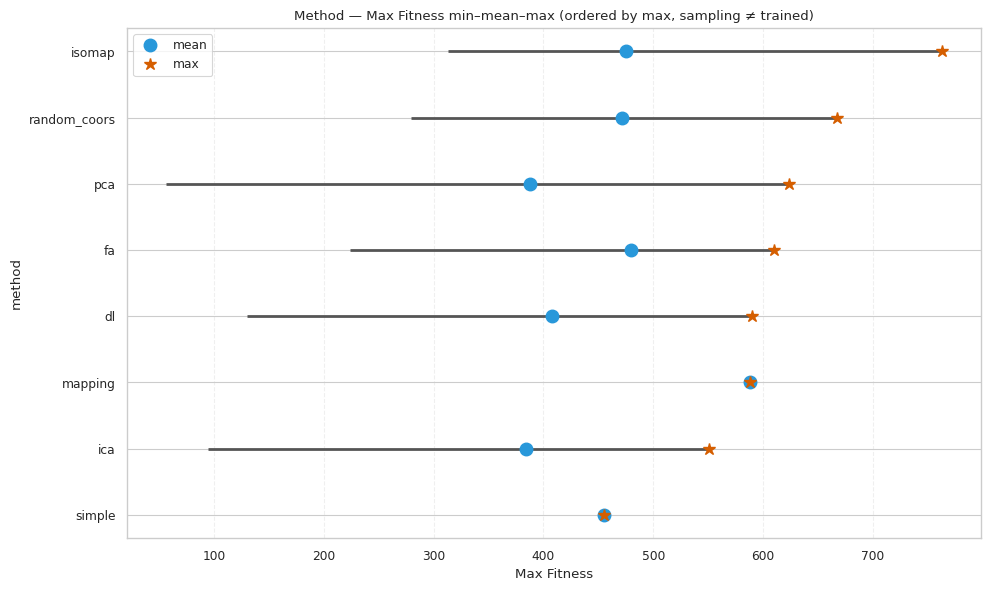

In [8]:
plot_range_mean_max(
    df_in=df_no_trained,
    group_col='method',
    value_col='max_fitness',
    title='Method — Max Fitness min–mean–max (ordered by max, sampling ≠ trained)',
    outpath=os.path.join(eval_output_dir, "main_effect_method_no_trained_range_mean_max.png"),
    order_by='max_val',
    ascending=True,
    figsize=(10, 6),
)

The reduction method, excluding the results from the random policy, plotted as main effect.

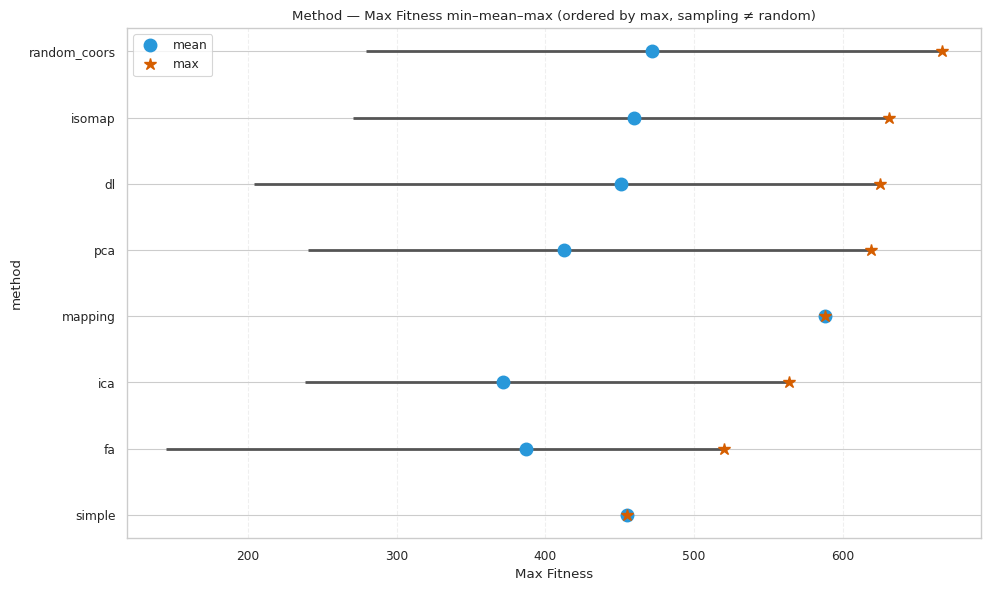

In [9]:
plot_range_mean_max(
    df_in=df_no_random,
    group_col='method',
    value_col='max_fitness',
    title='Method — Max Fitness min–mean–max (ordered by max, sampling ≠ random)',
    outpath=os.path.join(eval_output_dir, "main_effect_method_no_random_range_mean_max.png"),
    order_by='max_val',
    ascending=True,
    figsize=(10, 6),
)

The data sampling method plotted as main effect.

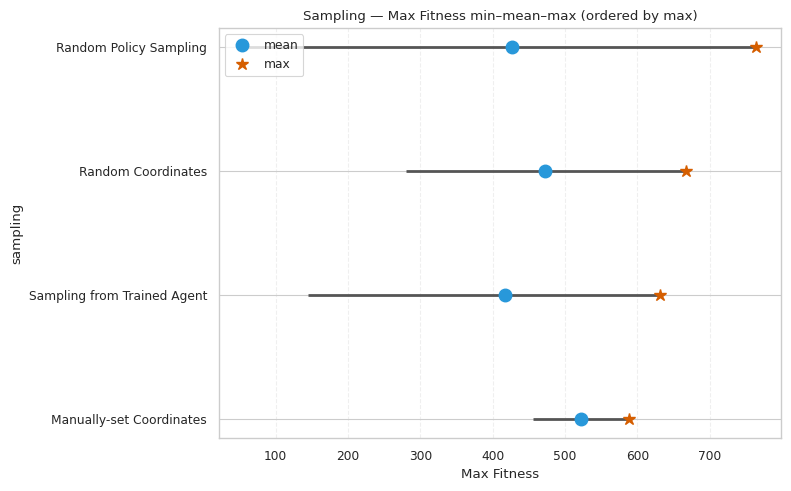

In [10]:
plot_range_mean_max(
    df_in=df,
    group_col='sampling',
    value_col='max_fitness',
    title='Sampling — Max Fitness min–mean–max (ordered by max)',
    outpath=os.path.join(eval_output_dir, "main_effect_sampling_range_mean_max.png"),
    order_by='max_val',
    ascending=True,        # set False to show best-at-top
    figsize=(8, 5)
)


The dimensionality plotted as main effect.

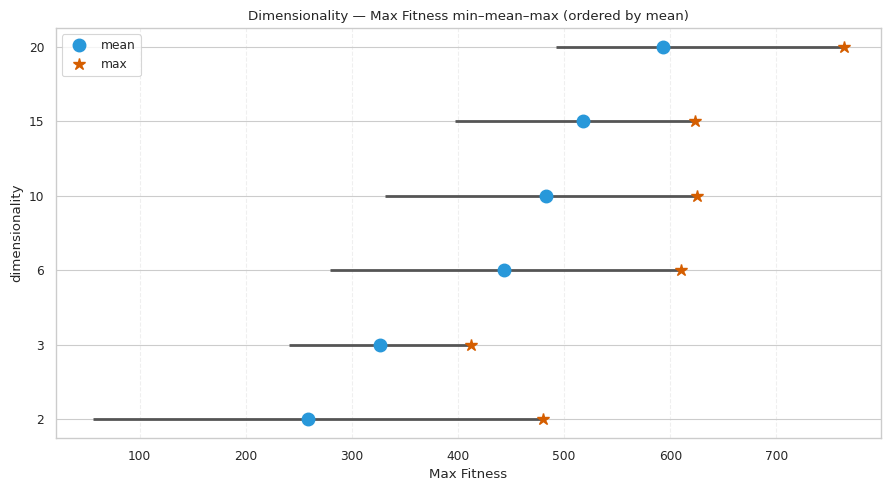

In [11]:
plot_range_mean_max(
    df_in=df,
    group_col='dimensionality',
    value_col='max_fitness',
    title='Dimensionality — Max Fitness min–mean–max (ordered by mean)',
    outpath=os.path.join(eval_output_dir, "main_effect_dimensionality_range_mean_max.png"),
    order_by='mean_val',
    ascending=True,
    figsize=(9, 5)
)


This chart also plots the dimensionality but excludes the manually configures substrates.

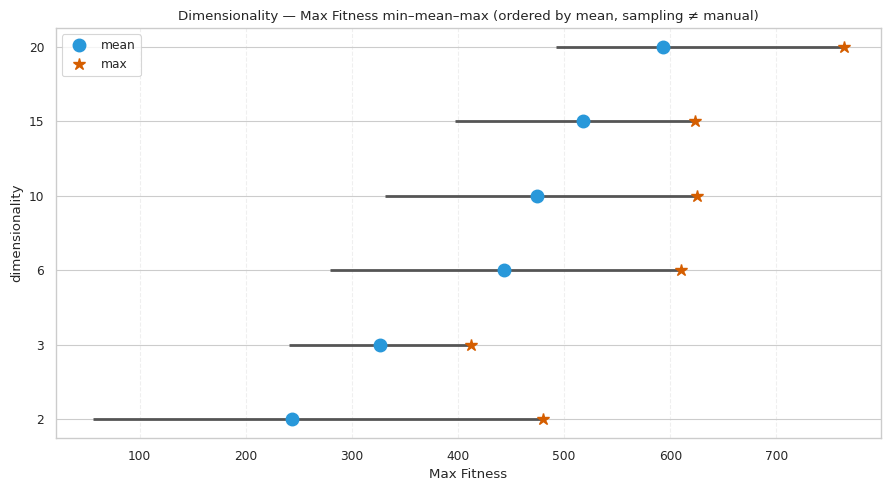

In [12]:
plot_range_mean_max(
    df_in=df_no_manual,
    group_col='dimensionality',
    value_col='max_fitness',
    title='Dimensionality — Max Fitness min–mean–max (ordered by mean, sampling ≠ manual)',
    outpath=os.path.join(eval_output_dir, "main_effect_dimensionality_no_manual_range_mean_max.png"),
    order_by='mean_val',
    ascending=True,
    figsize=(9, 5)
)

This chart plots dimensionality only for the data sampling based on a trained agent.

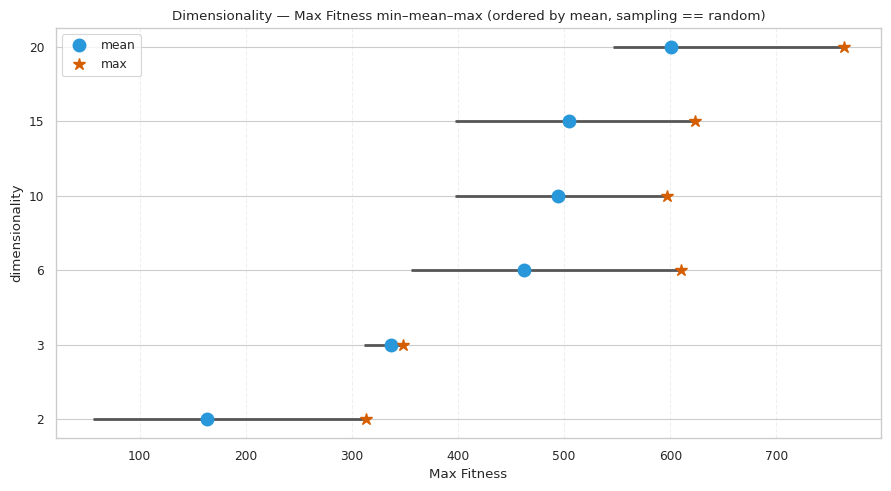

In [13]:
plot_range_mean_max(
    df_in=df_only_random,
    group_col='dimensionality',
    value_col='max_fitness',
    title='Dimensionality — Max Fitness min–mean–max (ordered by mean, sampling == random)',
    outpath=os.path.join(eval_output_dir, "main_effect_dimensionality_only_random_range_mean_max.png"),
    order_by='mean_val',
    ascending=True,
    figsize=(9, 5)
)

This chart plots dimensionality only for the data sampling based on a random action policy.

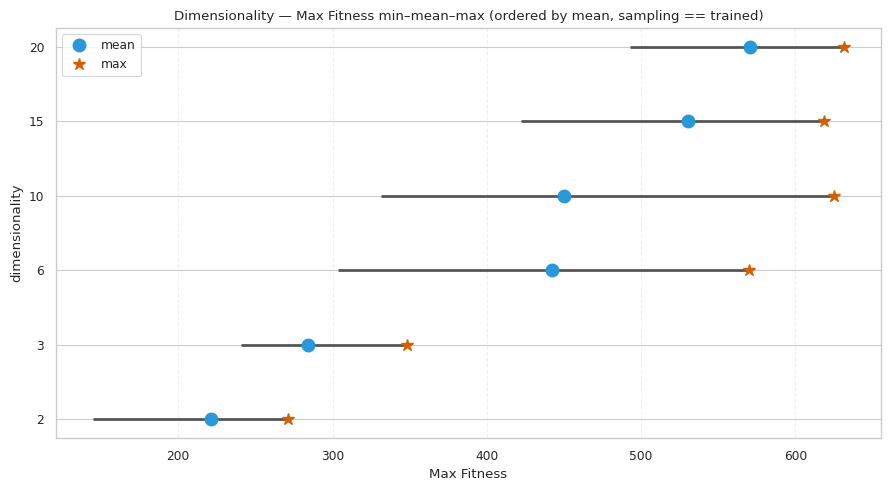

In [14]:
plot_range_mean_max(
    df_in=df_only_trained,
    group_col='dimensionality',
    value_col='max_fitness',
    title='Dimensionality — Max Fitness min–mean–max (ordered by mean, sampling == trained)',
    outpath=os.path.join(eval_output_dir, "main_effect_dimensionality_only_trained_range_mean_max.png"),
    order_by='mean_val',
    ascending=True,
    figsize=(9, 5)
)

### Interaction Charts

This chart shows interaction between different data sampling and reduction methods. For better interpretability, the manual/random coordinate configuration methods are moved to the end.

/tmp/ipykernel_87389/1433624666.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df['method']):
/tmp/ipykernel_87389/1433624666.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df['sampling']):


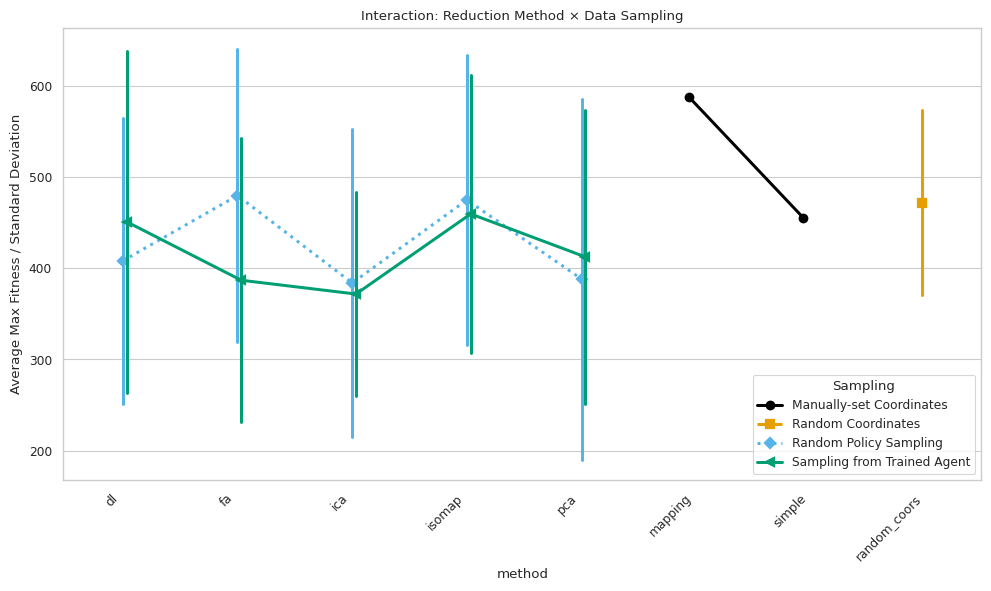

In [15]:
to_end = ["mapping", "simple", "random_coors"]

# Get current unique method levels in their current order
if pd.api.types.is_categorical_dtype(df['method']):
    methods_all = list(df['method'].cat.categories)
else:
    methods_all = list(pd.unique(df['method']))
# Build the order: everything except `to_end`, then append `to_end` (preserving their relative order)
methods_order = [m for m in methods_all if m not in to_end] + [m for m in to_end if m in methods_all]

# Also enforce hue order for consistency
if pd.api.types.is_categorical_dtype(df['sampling']):
    hue_levels = list(df['sampling'].cat.categories)
else:
    hue_levels = list(pd.unique(df['sampling']))

palette   = make_palette_for_levels(hue_levels)
markers   = markers_for_levels(hue_levels)
linestyles= linestyles_for_levels(hue_levels)

plt.figure(figsize=(10, 6))
ax = sns.pointplot(
    x='method',
    y='max_fitness',
    hue='sampling',
    data=df,
    order=methods_order,
    hue_order=hue_levels,
    errorbar='sd',
    dodge=True,
    palette=palette,
    markers=markers,
    linestyles=linestyles,
)
ax.set_title('Interaction: Reduction Method × Data Sampling')
ax.set_ylabel('Average Max Fitness / Standard Deviation')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sampling', loc='best', frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(eval_output_dir, "interaction_method_sampling.png"), dpi=150)
plt.show()
plt.close()


Interaction: Method × Dimensionality

/tmp/ipykernel_87389/3722920119.py:1: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  hue_levels = list(df['method'].unique()) if not pd.api.types.is_categorical_dtype(df['method']) else list(df['method'].cat.categories)


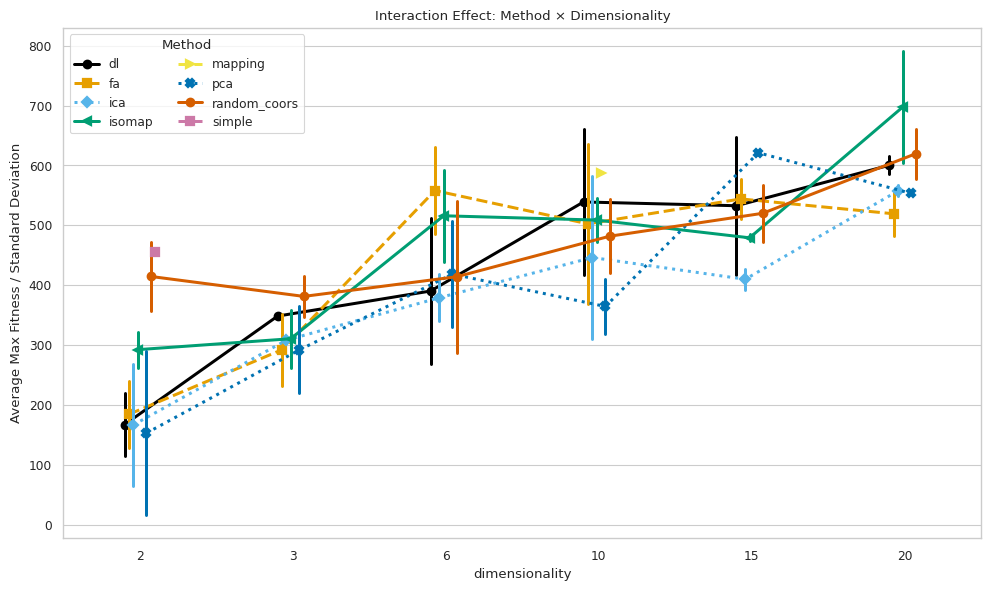

In [16]:
hue_levels = list(df['method'].unique()) if not pd.api.types.is_categorical_dtype(df['method']) else list(df['method'].cat.categories)
palette = make_palette_for_levels(hue_levels)
markers = markers_for_levels(hue_levels)
linestyles = linestyles_for_levels(hue_levels)

plt.figure(figsize=(10, 6))
ax = sns.pointplot(
    x='dimensionality',
    y='max_fitness',
    hue='method',
    data=df,
    errorbar='sd',
    dodge=True,
    palette=palette,
    markers=markers,
    linestyles=linestyles,
)
ax.set_title('Interaction Effect: Method × Dimensionality')
ax.set_ylabel('Average Max Fitness / Standard Deviation')
plt.legend(title='Method', loc='best', frameon=True, ncols=2 if len(hue_levels) > 6 else 1)
plt.tight_layout()
plt.savefig(os.path.join(eval_output_dir, "interaction_method_dimensionality.png"), dpi=150)
plt.show()
plt.close()


Interaction: Method × Dimensionality, excluding data samples from trained agent

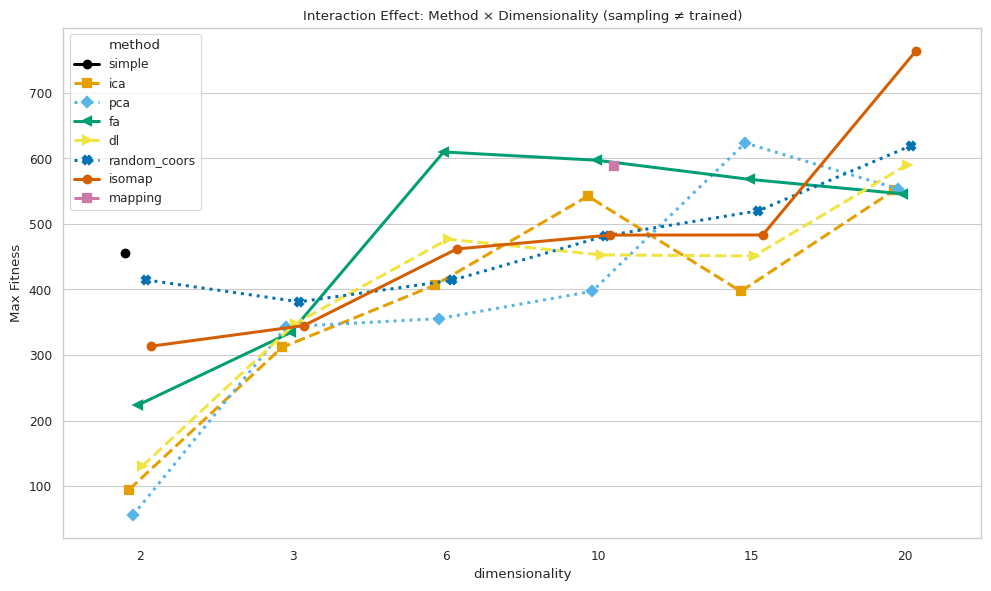

In [17]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='dimensionality',
    y='max_fitness',
    hue='method',
    data=df_no_trained,
    errorbar=None,
    palette=palette,
    markers=markers,
    linestyles=linestyles,
    dodge=True
)
plt.title('Interaction Effect: Method × Dimensionality (sampling ≠ trained)')
plt.ylabel('Max Fitness')
plt.tight_layout()
plt.savefig(os.path.join(eval_output_dir, "interaction_method_dimensionality_no_trained.png"))
plt.show()
plt.close()


Interaction: Method × Dimensionality, excluding data samples from random policy

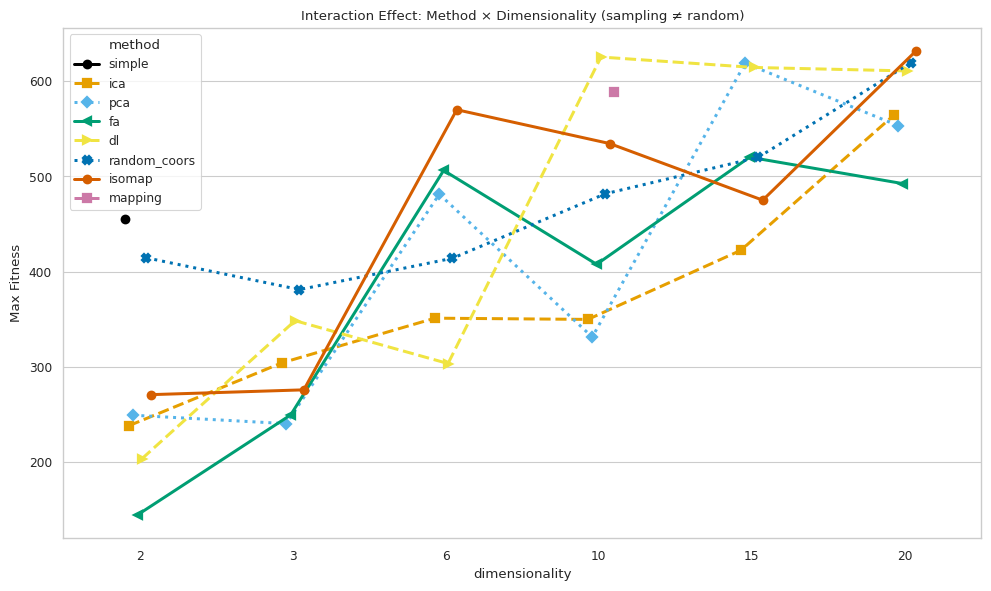

In [18]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='dimensionality',
    y='max_fitness',
    hue='method',
    data=df_no_random,
    errorbar=None,
    palette=palette,
    markers=markers,
    linestyles=linestyles,
    dodge=True
)
plt.title('Interaction Effect: Method × Dimensionality (sampling ≠ random)')
plt.ylabel('Max Fitness')
plt.tight_layout()
plt.savefig(os.path.join(eval_output_dir, "interaction_method_dimensionality_no_random.png"))
plt.show()
plt.close()

Interaction: Sampling × Dimensionality

/tmp/ipykernel_87389/1941969886.py:1: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  hue_levels = list(df['sampling'].unique()) if not pd.api.types.is_categorical_dtype(df['sampling']) else list(df['sampling'].cat.categories)


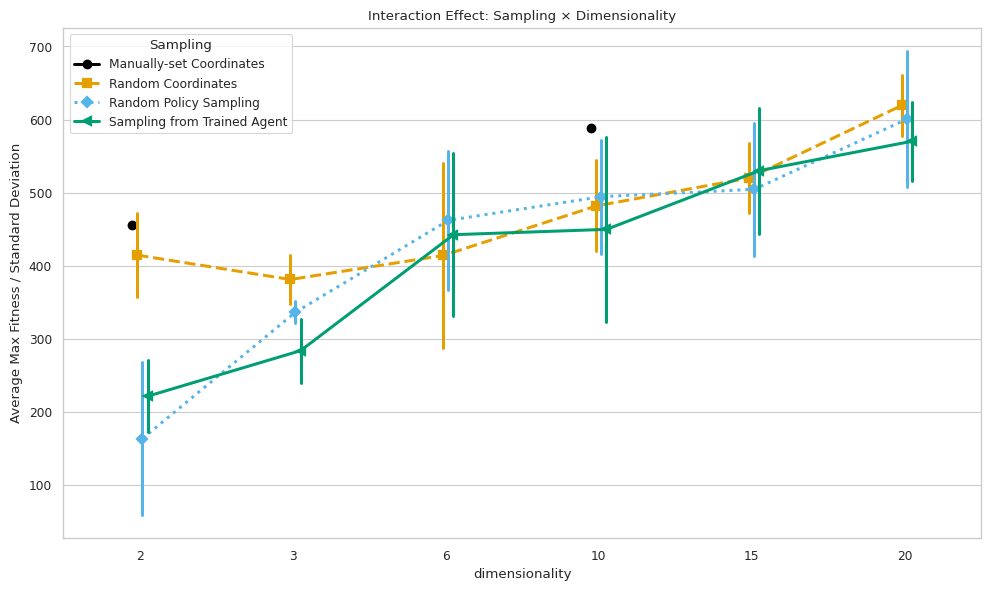

In [19]:
hue_levels = list(df['sampling'].unique()) if not pd.api.types.is_categorical_dtype(df['sampling']) else list(df['sampling'].cat.categories)
palette = make_palette_for_levels(hue_levels)
markers = markers_for_levels(hue_levels)
linestyles = linestyles_for_levels(hue_levels)

plt.figure(figsize=(10, 6))
ax = sns.pointplot(
    x='dimensionality',
    y='max_fitness',
    hue='sampling',
    data=df,
    errorbar='sd',
    dodge=True,
    palette=palette,
    markers=markers,
    linestyles=linestyles,
)
ax.set_title('Interaction Effect: Sampling × Dimensionality')
ax.set_ylabel('Average Max Fitness / Standard Deviation')
plt.legend(title='Sampling', loc='best', frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(eval_output_dir, "interaction_sampling_dimensionality.png"), dpi=150)
plt.show()
plt.close()
